In [2]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
from tensorflow.keras.models import load_model

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

/home/grad/si/24/guilherme.evangelista/anaconda3/envs/condaclustering/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-31 03:00:33.663932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 03:00:33.674341: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 03:00:33.677500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 03:00:33.685955: I tensorflow/core/platform/cpu_fe

In [62]:
import pandas as pd

# Carregar os dados
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)

# Carregar os IDs dos exames com interferências
caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)

# Obter uma lista dos IDs dos exames com interferências
interferencias_ids = interferencias['exam_id'].tolist()
print("Contagem das interferencias dos ECGs:", len(interferencias_ids))

# Contagem original dos dados
contagem_original = len(dados)

# Filtrar os dados para remover exames com interferências
dados_filtrados = dados[~dados['exam_id'].isin(interferencias_ids)]

# Contagem dos dados após remoção das interferências
contagem_filtrada = len(dados_filtrados)

# Selecionar os dados normais e ST com base nos critérios fornecidos
ecg_normal = dados_filtrados[
    ((dados_filtrados['trace_file'] == "exams_part17.hdf5") | 
     (dados_filtrados['trace_file'] == "exams_part16.hdf5")) & 
    (dados_filtrados['1dAVb'] == False) & 
   (dados_filtrados['RBBB'] == False) &
    (dados_filtrados['LBBB'] == False) &
    (dados_filtrados['SB'] == False) & 
    (dados_filtrados['ST'] == True) &
    (dados_filtrados['AF'] == False)
]

ecg_ST = dados_filtrados[
    ((dados_filtrados['trace_file'] == "exams_part17.hdf5") | 
     (dados_filtrados['trace_file'] == "exams_part16.hdf5")) & 
    (dados_filtrados['1dAVb'] == False) & 
   (dados_filtrados['RBBB'] == True) &
    (dados_filtrados['LBBB'] == False) &
    (dados_filtrados['SB'] == False) & 
    (dados_filtrados['ST'] == False) &
    (dados_filtrados['AF'] == False)
]

# Obter os IDs dos exames
ecg_normal_id = ecg_normal['exam_id'].tolist()
ecg_ST_id = ecg_ST['exam_id'].tolist()
print("Contagem dos IDs normais dos ECGs:", len(ecg_normal_id))
print("Contagem dos IDs ST:", len(ecg_ST_id))

# Selecionar os primeiros 500 IDs de ST e os primeiros 10000 IDs normais
ecg_ST = ecg_ST_id[:850]
ecg_normal = ecg_normal_id[:10000]

# Combinar os IDs para o conjunto de treinamento
ids_ecgs = ecg_ST + ecg_normal

# Selecionar IDs adicionais para o conjunto de treinamento
ids_ecgs_treino = ecg_normal_id[10000:11000] + ecg_ST_id[500:550]

# Verificar contagem dos IDs
print("Contagem dos IDs dos ECGs:", len(ids_ecgs))
print("Contagem dos IDs dos ECGs para treino:", len(ids_ecgs_treino))

# Verificar contagem antes e depois da remoção das interferências
print("Contagem original dos dados:", contagem_original)
print("Contagem dos dados após remoção das interferências:", contagem_filtrada)

Contagem das interferencias dos ECGs: 23741
Contagem dos IDs normais dos ECGs: 329
Contagem dos IDs ST: 504
Contagem dos IDs dos ECGs: 833
Contagem dos IDs dos ECGs para treino: 4
Contagem original dos dados: 345779
Contagem dos dados após remoção das interferências: 322038


In [63]:
import h5py
import numpy as np

def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings

# Caminho para o arquivo HDF5
path_to_file = '../Database/filtered_exams.hdf5'  # Substitua pelo caminho real do arquivo

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Indices das leads que queremos: D1 (0), AVL (3), V1 (6), V6 (11)
lead_indices = [0, 3, 6, 11]

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    tracings = get_ecg_data(path_to_file, exam_id)
    # Selecionar as leads desejadas
    selected_leads = tracings[:, lead_indices]
    # Achatar os dados
    flattened_leads = selected_leads.flatten()
    all_tracings.append(flattened_leads)

# Converter a lista de tracings em um array numpy
X = np.array(all_tracings)

# Verificação final do array X
print(f"Shape of final array X: {X.shape}")
print("Sample of flattened leads (first 5):")
print(X[:5])
# X agora está pronto para ser usado no autoencoder

Shape of final array X: (833, 16384)
Sample of flattened leads (first 5):
[[ 0.03259408 -0.00749365  0.04624622 ...  0.          0.00062374
   0.        ]
 [ 0.          0.          0.         ... -0.00133496 -0.00187438
   0.00115844]
 [-0.01195585  0.02354585  0.         ... -0.0081372  -0.06463924
  -0.00757902]
 [ 0.00247034 -0.00115714 -0.00499965 ...  0.          0.00029684
  -0.00492763]
 [-0.19785531  0.1415684   0.05522539 ... -0.05329428 -0.0688311
   0.07553487]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


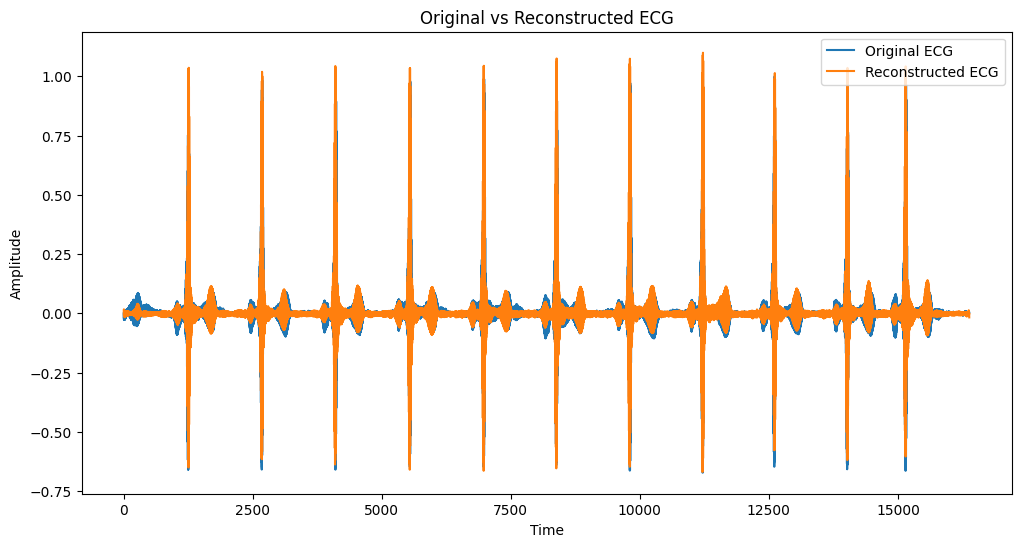

In [15]:
from sklearn.model_selection import train_test_split


autoencoder = tf.keras.models.load_model('../Algoritmos/modelos/autoencoder_model_128.keras')
# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()


In [ ]:
#X_TREINO

exam_ids_to_cluster_treino = ids_ecgs_treino  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster_treino:
    tracings = get_ecg_data(path_to_file, exam_id)
    aa = np.array(tracings.T)
    all_tracings.append(aa)

# X será um array com um único array dentro, contendo todos os números do tracings.T
X_TREINO = np.array(all_tracings)
 
# Usando squeeze
X_TREINO = np.squeeze(X_TREINO[:, 1, :])

In [64]:
#DIMINUIR DIMENSAO DE X PELO AUTOENCODER(128)

# Carregar o modelo autoencoder
autoencoder = tf.keras.models.load_model('../Algoritmos/modelos/autoencoder_model_128.keras')

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X
X_encoded = encoder.predict(X)

# X_encoded agora contém os vetores de 128 números para cada entrada em X
print(X_encoded.shape)  # Deve ser (10500, 128, 1)

# Remover a última dimensão para obter um vetor 2D
X_encoded_2d = np.squeeze(X_encoded)
print(X_encoded_2d.shape)  # Deve ser (10500, 128)

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
(833, 128)
(833, 128)


In [10]:
#DIMINUIR DIMENSAO DE X_TREINO PELO AUTOENCODER(128)


# Carregar o modelo autoencoder
autoencoder = tf.keras.models.load_model('modelos/autoencoder_model.keras')

# Extrair o modelo encoder a partir do autoencoder treinado
encoder = autoencoder.get_layer("encoder")

# Carregar os dados (este é um exemplo, você deve carregar seus dados reais)
# Supondo que seu vetor X_TREINO já esteja carregado como uma matriz numpy com shape (10500, 4096)
# X_TREINO = np.load('seu_arquivo_de_dados.npy')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X_TREINO = X_TREINO / np.max(np.abs(X_TREINO), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X_TREINO = X_TREINO.reshape((X_TREINO.shape[0], X_TREINO.shape[1], 1))

# Obter os vetores codificados para todo o conjunto X_TREINO
X_encoded = encoder.predict(X_TREINO)

# X_encoded agora contém os vetores de 128 números para cada entrada em X_TREINO


# Remover a última dimensão para obter um vetor 2D
X_TREINO_encoded_2d = np.squeeze(X_encoded)



33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [74]:
#DIMINUIR DIMENSAO DE X PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=4, random_state=42)
X_reduced = umap_reducer.fit_transform(X_normalized)

In [90]:
#DIMINUIR DIMENSAO DE X_TREINO PELO UMAP(16)
warnings.filterwarnings('ignore', message="n_jobs value.*overridden to 1 by setting random_state.*")
# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_TREINO_encoded_2d)
# Aplicação do UMAP
umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, n_components=32, random_state=42)
X_TREINO_reduced = umap_reducer.fit_transform(X_normalized)

NameError: name 'X_TREINO_encoded_2d' is not defined

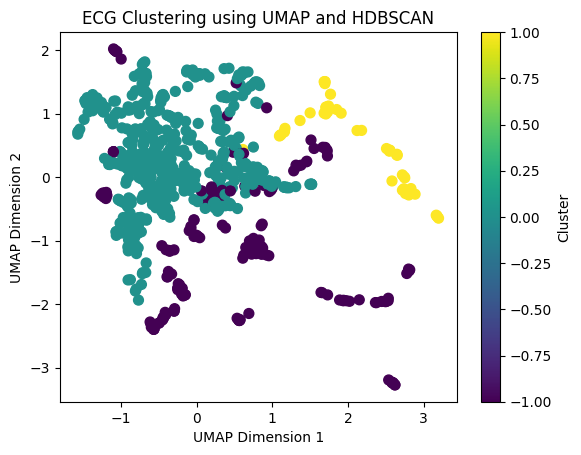

Silhouette Score: 0.17742007970809937
   cluster  1dAVb  RBBB  LBBB  SB  ST  AF  normal_ecg
0       -1      0   118    64   0   0   0           0
1        0      0   373   228   0   0   0           0
2        1      0    13    37   0   0   0           0


In [75]:
#CLUSTERIZACAO HDBSCAN
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

dbscan = HDBSCAN(min_cluster_size=50, min_samples=5)
labels = dbscan.fit_predict(X_reduced_scaled)
# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster')
plt.show()
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')


# Carregar os dados do CSV
metadata = pd.read_csv("../Database/exams.csv")

# Criar um DataFrame para os resultados do clustering
cluster_results = pd.DataFrame({
    'exam_id': exam_ids_to_cluster,
    'cluster': labels
})

# Mesclar os resultados do clustering com os metadados dos exames
merged_data = cluster_results.merge(metadata, on='exam_id')

# Contar a quantidade de doenças e ECGs normais em cada cluster
cluster_summary = merged_data.groupby('cluster').agg({
    '1dAVb': 'sum',
    'RBBB': 'sum',
    'LBBB': 'sum',
    'SB': 'sum',
    'ST': 'sum',
    'AF': 'sum',
    'normal_ecg': 'sum'
}).reset_index()

# Mostrar o resumo por cluster
print(cluster_summary)

In [ ]:
#TENTAR PREVER O TREINO NOS CLUSTERS
# Normalizar os dados
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)
new_data_scaled = scaler.transform(X_TREINO_reduced)

# Treinar o modelo HDBSCAN com prediction_data=True
dbscan = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=5, prediction_data=True)
labels = dbscan.fit_predict(X_reduced_scaled)

# Visualização dos Resultados
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('ECG Clustering using UMAP and HDBSCAN')
plt.colorbar(label='Cluster')
plt.show()

# Calcular Silhouette Score
silhouette_avg = silhouette_score(X_reduced_scaled, labels)
print(f'Silhouette Score: {silhouette_avg}')

# Para predizer novos dados
new_data = new_data_scaled # Certifique-se de que seus novos dados estão normalizados corretamente

# Usar approximate_predict para prever os rótulos dos novos dados
try:
    new_labels, new_probabilities = hdbscan.approximate_predict(dbscan, new_data)
except AttributeError as e:
    print("Erro na previsão: ", e)
    new_labels = np.array([])

# Configurar para mostrar todos os elementos no print
np.set_printoptions(threshold=np.inf)

print("New labels:", new_labels)
print("New probabilities:", new_probabilities)


KeyboardInterrupt

